<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>

## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите файл с ответами в соответствующем Programming Assignment. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/12VB7kmzDoSVzSpQNaJp0tR-2t8K8PynQopP3dypf7i4).  

In [1]:
# !pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.20.0

numpy      : 1.19.2
scipy      : 1.5.3
pandas     : 1.2.1
matplotlib : 3.3.4
statsmodels: 0.12.1
sklearn    : 0.24.1

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : AMD64 Family 23 Model 1 Stepping 1, AuthenticAMD
CPU cores   : 16
Architecture: 64bit

Git hash: 59643f693d26becf2b4a200909b56b5698ce3513



In [3]:
# не запускать
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.20.0

numpy      : 1.19.2
scipy      : 1.5.3
pandas     : 1.2.1
matplotlib : 3.3.4
statsmodels: 0.12.1
sklearn    : 0.24.1

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : AMD64 Family 23 Model 1 Stepping 1, AuthenticAMD
CPU cores   : 16
Architecture: 64bit

Git hash: 59643f693d26becf2b4a200909b56b5698ce3513



In [4]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [5]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

In [6]:
def write_answer_to_file(answer, file_address):
    with open(file_address, 'w') as out_f:
        out_f.write(str(answer))

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [7]:
# !unzip capstone_user_identification.zip

In [8]:
with open(os.path.join(PATH_TO_DATA, 'sparse_features',  'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 'sparse_features', 'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [9]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [11]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [12]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [13]:
from sklearn.neighbors import KNeighborsClassifier

In [14]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=1)

In [15]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=1, n_neighbors=100)

**<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

Точность на кросс-валидации

In [16]:
knn_score_cv = cross_val_score(knn, X_train, y_train, cv=skf, scoring='accuracy')
knn_score_cv

array([0.56598598, 0.55409936, 0.55792683])

Точность на отложенной выборке

In [17]:
accuracy_score(y_valid, knn.predict(X_valid))

0.584024650391088

In [18]:
knn_score_val = knn.score(X_valid, y_valid)
knn_score_val

0.584024650391088

In [19]:
write_answer_to_file(f'{round(knn_score_cv.mean(), 3)} {round(knn_score_val, 3)}',
                     'answer4_1.txt')

**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [21]:
forest = RandomForestClassifier(n_estimators=100, random_state=17, oob_score=True, n_jobs=-1)

In [22]:
forest.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=17)

**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [23]:
rf_score_cv = forest.oob_score_
rf_score_cv

0.7225157488315384

In [24]:
rf_score_val = forest.score(X_valid, y_valid)
rf_score_val

0.7350082958046931

In [22]:
write_answer_to_file(f'{round(rf_score_cv, 3)} {round(rf_score_val, 3)}',
                     'answer4_2.txt')

In [23]:
!cat answer4_2.txt

0.723 0.735

**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [25]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [26]:
logit = LogisticRegression(random_state=17, n_jobs=-1)

In [27]:
logit.fit(X_train, y_train)

LogisticRegression(n_jobs=-1, random_state=17)

In [28]:
logit_score_cv = cross_val_score(logit, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1)
logit_score_cv

array([0.76104846, 0.74824749, 0.77256098])

In [29]:
logit_score_cv.mean()

0.7606189739891912

In [30]:
logit_score_val = logit.score(X_valid, y_valid)
logit_score_val

0.7767243422611994

**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [31]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(logit_c_values1, random_state=17, n_jobs=-1, multi_class='multinomial', cv=skf)
logit_grid_searcher1.fit(X_train, y_train)

Wall time: 9.25 s


LogisticRegressionCV(Cs=array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02]),
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     multi_class='multinomial', n_jobs=-1, random_state=17)

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [32]:
logit_mean_cv_scores1 = list(logit_grid_searcher1.scores_.values())[0].mean(axis=0)
logit_mean_cv_scores1

array([0.31954964, 0.47307397, 0.55202236, 0.64875035, 0.71438846,
       0.75177962, 0.76112704, 0.75838391, 0.75015382, 0.74060311])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [33]:
logit_grid_searcher1.C_[0], logit_mean_cv_scores1.max()

(1.0, 0.7611270421222956)

In [34]:
logit_c_values1[logit_mean_cv_scores1.argmax()]

1.0

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

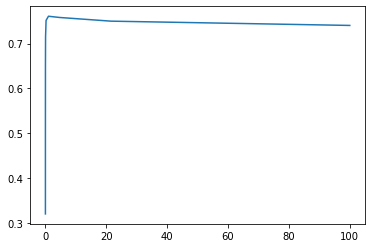

In [35]:
plt.plot(logit_c_values1, logit_mean_cv_scores1);

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [36]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(logit_c_values2, random_state=17, n_jobs=-1, multi_class='multinomial', cv=skf)
logit_grid_searcher2.fit(X_train, y_train)

Wall time: 22.2 s


LogisticRegressionCV(Cs=array([0.1       , 0.46315789, 0.82631579, 1.18947368, 1.55263158,
       1.91578947, 2.27894737, 2.64210526, 3.00526316, 3.36842105,
       3.73157895, 4.09473684, 4.45789474, 4.82105263, 5.18421053,
       5.54736842, 5.91052632, 6.27368421, 6.63684211, 7.        ]),
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     multi_class='multinomial', n_jobs=-1, random_state=17)

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [37]:
logit_mean_cv_scores2 = list(logit_grid_searcher2.scores_.values())[0].mean(axis=0)
logit_mean_cv_scores2

array([0.73481117, 0.75929815, 0.76122864, 0.76082216, 0.76122861,
       0.76153352, 0.75980615, 0.75939974, 0.75960293, 0.75950143,
       0.75919661, 0.75858698, 0.75777422, 0.75716465, 0.75706302,
       0.75635177, 0.75523425, 0.75523425, 0.7538118 , 0.75310051])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [38]:
logit_grid_searcher2.C_[0], logit_mean_cv_scores2.max()

(1.9157894736842107, 0.761533515213238)

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

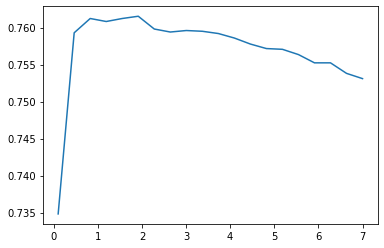

In [39]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [40]:
logit_cv_acc = logit_grid_searcher2.score(X_valid, y_valid)
logit_cv_acc

0.7790945721735009

**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [41]:
lr = LogisticRegression(C=logit_grid_searcher2.C_[0], random_state=17, n_jobs=-1)
lr.fit(X_train, y_train)

LogisticRegression(C=1.9157894736842107, n_jobs=-1, random_state=17)

In [42]:
lr_score_cv = cross_val_score(lr, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1)
lr_score_cv

array([0.76043889, 0.75251448, 0.77408537])

In [43]:
lr_score_val = lr.score(X_valid, y_valid)
lr_score_val

0.7817018250770325

In [115]:
write_answer_to_file(f'{round(lr_score_cv.mean(), 3)} {round(lr_score_val, 3)}',
                     'answer4_3.txt')

In [116]:
!cat answer4_3.txt

0.762 0.782

**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [44]:
from sklearn.svm import LinearSVC

In [45]:
svm = LinearSVC(C=1, random_state=17)
svm.fit(X_train, y_train)

LinearSVC(C=1, random_state=17)

In [46]:
svm_score_cv = cross_val_score(svm, X_train, y_train, cv=skf, n_jobs=-1)
svm_score_cv

array([0.75068577, 0.73270344, 0.7695122 ])

In [47]:
svm_score_cv.mean()

0.7509671352428245

In [48]:
svm_score_val = svm.score(X_valid, y_valid)
svm_score_val

0.7769613652524295

**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [49]:
np.linspace(1e-4, 1e4, 10)

array([1.0000000e-04, 1.1111112e+03, 2.2222223e+03, 3.3333334e+03,
       4.4444445e+03, 5.5555556e+03, 6.6666667e+03, 7.7777778e+03,
       8.8888889e+03, 1.0000000e+04])

In [50]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, param_grid=svm_params1, n_jobs=-1, cv=skf, scoring='accuracy', return_train_score=True)
svm_grid_searcher1.fit(X_train, y_train)

Wall time: 8.09 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             estimator=LinearSVC(C=1, random_state=17), n_jobs=-1,
             param_grid={'C': array([1.0000000e-04, 1.1111112e+03, 2.2222223e+03, 3.3333334e+03,
       4.4444445e+03, 5.5555556e+03, 6.6666667e+03, 7.7777778e+03,
       8.8888889e+03, 1.0000000e+04])},
             return_train_score=True, scoring='accuracy')

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [51]:
svm_grid_searcher1.best_params_, svm_grid_searcher1.best_score_

({'C': 5555.555600000001}, 0.6959968146237391)

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

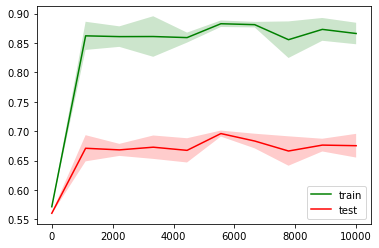

In [52]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`.**

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [53]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, param_grid=svm_params2, n_jobs=-1, cv=skf, scoring='accuracy', return_train_score=True)
svm_grid_searcher2.fit(X_train, y_train)

Wall time: 8.48 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             estimator=LinearSVC(C=1, random_state=17), n_jobs=-1,
             param_grid={'C': array([0.001     , 0.03544828, 0.06989655, 0.10434483, 0.1387931 ,
       0.17324138, 0.20768966, 0.24213793, 0.27658621, 0.31103448,
       0.34548276, 0.37993103, 0.41437931, 0.44882759, 0.48327586,
       0.51772414, 0.55217241, 0.58662069, 0.62106897, 0.65551724,
       0.68996552, 0.72441379, 0.75886207, 0.79331034, 0.82775862,
       0.8622069 , 0.89665517, 0.93110345, 0.96555172, 1.        ])},
             return_train_score=True, scoring='accuracy')

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [54]:
svm_grid_searcher2.best_params_, svm_grid_searcher2.best_score_

({'C': 0.10434482758620689}, 0.7670206386611259)

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

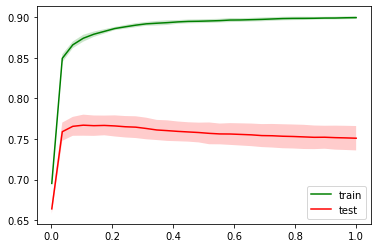

In [55]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [56]:
svm_grid_searcher2.score(X_valid, y_valid)

0.7807537331121118

**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [57]:
svm_score_cv = cross_val_score(svm_grid_searcher2.best_estimator_, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1)
svm_score_cv

array([0.76409631, 0.75281926, 0.78414634])

In [69]:
svm_score_cv.mean()

0.7670206386611259

In [58]:
svm_score_val = svm_grid_searcher2.score(X_valid, y_valid)
svm_score_val

0.7807537331121118

In [164]:
write_answer_to_file(f'{round(svm_score_cv.mean(), 3)} {round(svm_score_val, 3)}',
                     'answer4_4.txt')

In [165]:
!cat answer4_4.txt

0.767 0.781

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [127]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
#     from sklearn.exceptions import NotFittedError
    
    X_sparse = pd.read_pickle(path_to_X_pickle)
    y = pd.read_pickle(path_to_y_pickle)
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, y, random_state=random_state, 
                                                          test_size=test_size, stratify=y)
    
    accuracy_cv = cross_val_score(estimator, X_train, y_train, cv=cv, n_jobs=-1)
    
    
    estimator.fit(X_train, y_train)
    accuracy_ho = estimator.score(X_valid, y_valid)
#     try:
#         accuracy_ho = estimator.score(X_valid, y_valid)
#     except NotFittedError:

    
    return accuracy_cv.mean(), accuracy_ho

**Убедитесь, что функция работает.**

In [128]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'sparse_features', 'X_sparse_10users.pkl'),
        os.path.join(PATH_TO_DATA, 'sparse_features', 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

(0.7670206386611259, 0.7807537331121118)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [71]:
# linux

# !cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10_w10.pkl 
# !cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10_w10.pkl 
# !cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 
# !cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10_w10.pkl 

In [76]:
# windows

!copy $PATH_TO_DATA\sparse_features\X_sparse_10users.pkl $PATH_TO_DATA\sparse_features\X_sparse_10users_s10_w10.pkl 
!copy $PATH_TO_DATA\sparse_features\X_sparse_150users.pkl $PATH_TO_DATA\sparse_features\X_sparse_150users_s10_w10.pkl 
!copy $PATH_TO_DATA\sparse_features\y_10users.pkl $PATH_TO_DATA\sparse_features\y_10users_s10_w10.pkl 
!copy $PATH_TO_DATA\sparse_features\y_150users.pkl $PATH_TO_DATA\sparse_features\y_150users_s10_w10.pkl 

        1 file(s) copied.
        1 file(s) copied.
        1 file(s) copied.
        1 file(s) copied.


In [135]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, 'sparse_features', f'X_sparse_10users_s{session_length}_w{window_size}.pkl')
        path_to_y_pkl = os.path.join(PATH_TO_DATA, 'sparse_features', f'y_10users_s{session_length}_w{window_size}.pkl')
        print('Session lenght:', session_length)
        print('Windows size:', window_size)
        print('CV accuracy, holdout accuracy:', model_assessment(
            estimator=estimator,
            path_to_X_pickle=path_to_X_pkl,
            path_to_y_pickle=path_to_y_pkl,
            cv=skf
            )
        )
        print()

Session lenght: 15
Windows size: 10
CV accuracy, holdout accuracy: (0.8243252292702751, 0.8404835269021095)

Session lenght: 10
Windows size: 10
CV accuracy, holdout accuracy: (0.7670206386611259, 0.7807537331121118)

Session lenght: 15
Windows size: 7
CV accuracy, holdout accuracy: (0.8495024256089474, 0.8543222166915547)

Session lenght: 10
Windows size: 7
CV accuracy, holdout accuracy: (0.7983645917156946, 0.8073668491786958)

Session lenght: 7
Windows size: 7
CV accuracy, holdout accuracy: (0.754765400423003, 0.7617388418782147)

Session lenght: 15
Windows size: 5
CV accuracy, holdout accuracy: (0.8670355547005402, 0.8752963489805595)

Session lenght: 10
Windows size: 5
CV accuracy, holdout accuracy: (0.8177520250854086, 0.8245614035087719)

Session lenght: 7
Windows size: 5
CV accuracy, holdout accuracy: (0.772939529035208, 0.7853247984826932)

Session lenght: 5
Windows size: 5
CV accuracy, holdout accuracy: (0.7254849424351582, 0.7362494073020389)

Wall time: 15.6 s


Качество модели зависит от session_length, window_size следующим образом: чем больше длина сессии и чем меньше шаг (размер окна), тем выше качество.

**<font color='red'>Вопрос 5. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [98]:
svm_grid_searcher2.best_params_['C']

0.10434482758620689

In [136]:
acc_cv_10users_s15_w5, acc_ho_10users_s15_w5 = model_assessment(
    estimator=LinearSVC(C=svm_grid_searcher2.best_params_['C'], random_state=17),
    path_to_X_pickle=os.path.join(PATH_TO_DATA, 'sparse_features', 'X_sparse_10users_s15_w5.pkl'),
    path_to_y_pickle=os.path.join(PATH_TO_DATA, 'sparse_features', 'y_10users_s15_w5.pkl'),
    cv=skf
)
acc_cv_10users_s15_w5, acc_ho_10users_s15_w5

(0.8670355547005402, 0.8752963489805595)

In [132]:
write_answer_to_file(f'{round(acc_cv_10users_s15_w5, 3)} {round(acc_ho_10users_s15_w5, 3)}',
                     'answer4_5.txt')

In [137]:
# %pycat ./answers/answer4_2.txt
print(round(acc_cv_s15_w5, 3), round(acc_ho_10users_s15_w5, 3))

0.867 0.875


**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :)**

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [146]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7), (10,10)]:
    path_to_X_pkl = os.path.join(PATH_TO_DATA, 'sparse_features', f'X_sparse_150users_s{session_length}_w{window_size}.pkl')
    path_to_y_pkl = os.path.join(PATH_TO_DATA, 'sparse_features', f'y_150users_s{session_length}_w{window_size}.pkl')
    print('Session lenght:', session_length)
    print('Windows size:', window_size)
    print('CV accuracy, holdout accuracy:', model_assessment(
        estimator=estimator,
        path_to_X_pickle=path_to_X_pkl,
        path_to_y_pickle=path_to_y_pkl,
        cv=skf
        )
    )
    print()

Session lenght: 5
Windows size: 5
CV accuracy, holdout accuracy: (0.4083611011164474, 0.42171606560568453)

Session lenght: 7
Windows size: 7
CV accuracy, holdout accuracy: (0.4366487102001489, 0.45295840855673264)

Session lenght: 10
Windows size: 10
CV accuracy, holdout accuracy: (0.46307591254574465, 0.4836276942538802)

Wall time: 9min 55s


**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [143]:
%%time
acc_cv_150users_s10_w10, acc_ho_150users_s10_w10 = model_assessment(
    estimator=LinearSVC(C=svm_grid_searcher2.best_params_['C'], random_state=17),
    path_to_X_pickle=os.path.join(PATH_TO_DATA, 'sparse_features', 'X_sparse_150users_s10_w10.pkl'),
    path_to_y_pickle=os.path.join(PATH_TO_DATA, 'sparse_features', 'y_150users_s10_w10.pkl'),
    cv=skf
)
acc_cv_150users_s10_w10, acc_ho_150users_s10_w10

Wall time: 3min 3s


(0.46307591254574465, 0.4836276942538802)

In [139]:
write_answer_to_file(f'{round(acc_cv_150users_s15_w5, 3)} {round(acc_ho_150users_s15_w5, 3)}',
                     'answer4_6.txt')

In [145]:
# %pycat ./answers/answer4_2.txt
print(round(acc_cv_150users_s10_w10, 3), round(acc_ho_150users_s10_w10, 3))

0.463 0.484


## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо.**

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [148]:
with open(os.path.join(PATH_TO_DATA,'sparse_features', 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'sparse_features', 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [149]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

Решим задачу точно по условию - возьмём лучший С из logit_grid_searcher2 (который искали для 10 пользователей). Однако ответ не принимается грейдером.

In [165]:
logit_grid_searcher2.C_[0] # лучший С

1.9157894736842107

In [271]:
%%time
logit_cv_150users_ = LogisticRegressionCV(Cs=[logit_grid_searcher2.C_[0]], multi_class='ovr', 
                                          random_state=17, n_jobs=-1, cv=skf)
logit_cv_150users_.fit(X_train_150, y_train_150)

Wall time: 4min 18s


LogisticRegressionCV(Cs=[1.9157894736842107],
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     multi_class='ovr', n_jobs=-1, random_state=17)

Решим задачу для прохода грейдера. Будем подбирать лучший С на сете из 150 пользователей.

In [277]:
%%time # поиск по всем 20 С на 150 пользователях
logit_cv_150users = LogisticRegressionCV(Cs=logit_c_values2, multi_class='ovr', random_state=17, n_jobs=-1, cv=skf)
logit_cv_150users.fit(X_train_150, y_train_150)

Wall time: 22min 41s


LogisticRegressionCV(Cs=array([0.1       , 0.46315789, 0.82631579, 1.18947368, 1.55263158,
       1.91578947, 2.27894737, 2.64210526, 3.00526316, 3.36842105,
       3.73157895, 4.09473684, 4.45789474, 4.82105263, 5.18421053,
       5.54736842, 5.91052632, 6.27368421, 6.63684211, 7.        ]),
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     multi_class='ovr', n_jobs=-1, random_state=17)

In [278]:
# сохранение модели на всякий случай
# with open('logit_cv_150users.pickle', 'wb') as handle:
#     pickle.dump(logit_cv_150users, handle, protocol=pickle.HIGHEST_PROTOCOL)

**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

Решение для одного С

In [283]:
# для значения logit_grid_searcher2.C_[0]
cv_scores_by_user = {}
for user_id, scores in logit_cv_150users_.scores_.items():
    cv_scores_by_user[user_id] = scores.mean()
    print(f'User {user_id}, CV score: {scores.mean()}')

User 6, CV score: 0.9960797806345333
User 13, CV score: 0.9963091551718745
User 15, CV score: 0.995256117523172
User 16, CV score: 0.9918467778090561
User 28, CV score: 0.9903558433163387
User 31, CV score: 0.9944011760658097
User 33, CV score: 0.9937651830304547
User 39, CV score: 0.9858830398381867
User 46, CV score: 0.9980398903172666
User 49, CV score: 0.9951935608311699
User 50, CV score: 0.9943281932584739
User 53, CV score: 0.9937130524537862
User 65, CV score: 0.9969451482072295
User 66, CV score: 0.9948077945638234
User 82, CV score: 0.9963717118638766
User 85, CV score: 0.9963717118638766
User 89, CV score: 0.9908771490830232
User 92, CV score: 0.994422028296477
User 100, CV score: 0.9944950111038128
User 102, CV score: 0.9911586541970326
User 103, CV score: 0.9805448687873385
User 105, CV score: 0.9969034437458948
User 106, CV score: 0.9948494990251583
User 118, CV score: 0.9909292796596917
User 119, CV score: 0.9965906602858841
User 120, CV score: 0.994286488797139
User 126

Решение для 20 С

In [309]:
# формируем словари user_id: accuracy для всех С
cv_scores_by_user_c = []
for c in range(20):
    cv_scores_by_user_c.append({k: v.mean(axis=0)[c] for k, v in logit_cv_150users.scores_.items()})

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

Решение для одного С

In [284]:
class_distr = np.bincount(y_train_150.astype('int'))
acc_diff_vs_constant = {}

for user_id in np.unique(y_train_150):
    acc_diff_vs_constant[user_id] = cv_scores_by_user[user_id] - (1 - class_distr[user_id]/len(y_train_150))

In [285]:
acc_diff_vs_constant

{6: 0.011677249173730253,
 13: 0.000604714689353858,
 15: 0.0008549414573623126,
 16: 0.007131462888242401,
 28: 0.0024084326420819036,
 31: -5.2130576668418804e-05,
 33: 0.0012198554940414663,
 39: 0.0019705357980670524,
 46: 0.0009174981493643708,
 49: 0.0013658211087130834,
 50: 0.00017724396067275716,
 53: 0.0016681784533899569,
 65: 2.0852230667389726e-05,
 66: -5.213057666852983e-05,
 82: 2.0852230667389726e-05,
 85: 0.00017724396067264614,
 89: 0.0008028108806940049,
 92: 0.0002710789986758444,
 100: -0.0002502267680085657,
 102: 0.0007194019580243349,
 103: 0.003544879213453811,
 105: 0.0008862198033635638,
 106: 0.007631916424259533,
 118: 0.0009279242646983432,
 119: 0.0006464191506886374,
 120: 0.0006255669200211367,
 126: 0.001011333187367791,
 127: 0.00409746332613925,
 128: 0.005098370398173291,
 138: -5.2130576668418804e-05,
 158: 0.00028150511400959477,
 160: 0.00028150511400959477,
 165: 0.00028150511400959477,
 172: 0.00022937453734106494,
 177: 0.0002710789986759554,

In [286]:
num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()
num_better_than_default

127

Решение для 20 С

In [316]:
acc_diff_vs_constant_c = []
for c in range(20):
    acc_diff_vs_constant_c.append(
        {user_id: cv_scores_by_user_c[c][user_id] - (1 - class_distr[user_id]/len(y_train_150)) 
         for user_id in np.unique(y_train_150)}
    )

In [323]:
num_better_than_default_c = []
for c in range(20):
    num_better_than_default_c.append((np.array(list(acc_diff_vs_constant_c[c].values())) > 0).sum())
num_better_than_default_c

[129,
 134,
 133,
 130,
 130,
 127,
 125,
 124,
 123,
 122,
 123,
 123,
 119,
 120,
 119,
 118,
 118,
 117,
 117,
 117]

**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

Решение для одного С

In [287]:
num_better_than_default / 150

0.8466666666666667

Решение для 20 С

In [325]:
np.array(num_better_than_default_c) / 150

array([0.86      , 0.89333333, 0.88666667, 0.86666667, 0.86666667,
       0.84666667, 0.83333333, 0.82666667, 0.82      , 0.81333333,
       0.82      , 0.82      , 0.79333333, 0.8       , 0.79333333,
       0.78666667, 0.78666667, 0.78      , 0.78      , 0.78      ])

In [333]:
# лучший С
logit_cv_150users.Cs_[1]

0.4631578947368421

Подошёл ответ 0.82

In [327]:
write_answer_to_file(0.82, 'answer4_7.txt')

**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [341]:
y_binary_128 = [int(i == 128) for i in y_150users]

In [342]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, xlabel='Training Set Size', ylabel='score'):
    
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none', facecolor=lines[0].get_color(), alpha=0.2)
        
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [348]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator, X_sparse_150users, y_binary_128, train_sizes=train_sizes)

Wall time: 33.3 s


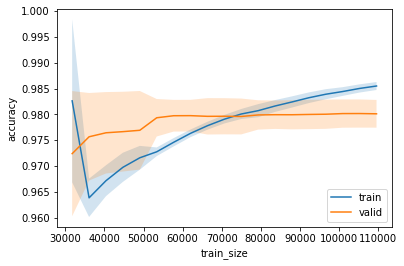

In [349]:
plot_learning_curve(val_train, val_test, n_train, xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

На трейне качество очевидно растёт с ростом размера выборки.

Однако, на тесте качество не растёт, начиная с размера ~55000.

Новые данные не помогут улучшить качество модели.

## Пути улучшения
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей


На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.